# Train a `bioLORD` model with `developing human immune across tissue` for `bioLORD` (B-cells)

The data was generated by Suo et al.[[1]](https://www.science.org/doi/full/10.1126/science.abo0510) and downloaded from [Lymphoid cells](https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.LYMPHOID.embedding.h5ad). <br>
The complete dataset contains a cross-tissue single-cell atlas of developing human immune cells across prenatal hematopoietic, lymphoid, and nonlymphoid peripheral organs. This includes over 900,000 cells from which we identified over 100 cell states.

[[1] Suo, Chenqu, Emma Dann, Issac Goh, Laura Jardine, Vitalii Kleshchevnikov, Jong-Eun Park, Rachel A. Botting et al. "Mapping the developing human immune system across organs." Science (2022): eabo0510.](https://www.science.org/doi/full/10.1126/science.abo0510)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("/cs/usr/bar246802/bar246802/SandBox2023/biolord_immune_bcells/utils") # add utils
sys.path.append("/cs/usr/bar246802/bar246802/SandBox2023/biolord") # set path)

In [3]:
import biolord
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import torch
import umap.plot
import seaborn as sns
import matplotlib.pyplot as plt

/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.14.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
[rank: 0] Global seed set to 0


In [4]:
print(f"PyTorch version: {torch.__version__}")
# Set the device      
device = "gpu" if torch.backends.cuda.is_built() else "cpu"
print(f"Using device: {device}")

PyTorch version: 1.13.1+cu117
Using device: gpu


In [5]:
from tqdm import tqdm
tqdm(disable=True, total=0)  # initialise internal lock

In [6]:
import mplscience
mplscience.set_style()

plt.rcParams['legend.scatterpoints'] = 1

## Set parameters

In [8]:
DATA_DIR = "../data/"
SAVE_DIR = "../output/"
FIG_DIR = "../figures/"

## Import processed data

In [9]:
adata = sc.read(DATA_DIR + "biolord_immune_bcells_bm.h5ad")

In [10]:
adata.obs["split"].value_counts()

train    57436
test      6382
ood        160
Name: split, dtype: int64

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    categorical_attributes_keys=["celltype", "organ", "age"],
    retrieval_attribute_key="sex",
)

## Train model

In [ ]:
# reconstruction_penalty
N_LATENT_ATTRIBUTE_CATEGORICAL = 4
module_params = {
    "autoencoder_width": 128,
    "autoencoder_depth": 2,
    "attribute_nn_width": 256,
    "attribute_nn_depth": 2,
    "n_latent_attribute_categorical": N_LATENT_ATTRIBUTE_CATEGORICAL,
    "loss_ae": "gauss",
    "loss_ordered_attribute": "gauss",
    "reconstruction_penalty": 1e2,
    "unknown_attribute_penalty": 1e1,
    "unknown_attribute_noise_param": 1e-1,
    "attribute_dropout_rate": 0.1,
    "use_batch_norm": False,
    "use_layer_norm": False,
    "seed": 42,
}


trainer_params = {
    "n_epochs_warmup": 0,
    "autoencoder_lr": 1e-4,
    "autoencoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

In [ ]:
model = biolord.Biolord(
    adata=adata,
    n_latent=32,
    model_name="immune_bcells",
    module_params=module_params,
    train_classifiers=False,
    split_key="split",
)

In [ ]:
model.train(max_epochs=1000,
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping=True,
            early_stopping_patience=20,            
            check_val_every_n_epoch=10,
            num_workers=1)

## Evaluate the trained model

In [ ]:
size = N_LATENT_ATTRIBUTE_CATEGORICAL
vals = [
    "generative_mean_accuracy", "generative_var_accuracy", "biolord_metric"
]
fig, axs = plt.subplots(nrows=1,
                        ncols=len(vals),
                        figsize=(size * len(vals), size))

model.epoch_history = pd.DataFrame().from_dict(
    model.training_plan.epoch_history)
for i, val in enumerate(vals):
    sns.lineplot(
        x="epoch",
        y=val,
        hue="mode",
        data=model.epoch_history[model.epoch_history["mode"] == "valid"],
        ax=axs[i],
    )

plt.tight_layout()
plt.show()

## Save the trained model

In [ ]:
model.save(SAVE_DIR + "trained_model")

## Load saved model

In [11]:
model = biolord.Biolord.load(dir_path=SAVE_DIR + "trained_model", adata=adata, use_gpu=True)

INFO     File ../output/trained_model/model.pt already downloaded                                                  


[rank: 0] Global seed set to 42


## Assess performance

In [12]:
idx_train = np.where(
    (adata.obs["split"] == "train") 
)[0]

adata_train= adata[idx_train].copy()


idx_test = np.where(
    (adata.obs["split"] == "test")
)[0]

adata_test = adata[idx_test].copy()

dataset_train = model.get_dataset(adata_train)
dataset_test = model.get_dataset(adata_test)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


## Cluster embeddings

In [13]:
import itertools

In [14]:
attributes_map = {
    "celltype": model.categorical_attributes_map["celltype"],
    "organ": model.categorical_attributes_map["organ"]
}

In [15]:
transf_embeddings_attributes = {
    attribute_:
    model.get_categorical_attribute_embeddings(attribute_key=attribute_)
    for attribute_ in model.categorical_attributes_map
}

keys = list(
    itertools.product(*[
        list(model.categorical_attributes_map[attribute_].keys())
        for attribute_ in model.categorical_attributes_map
    ]))

transf_embeddings_attributes_dict = {
    "_".join([str(k) for k in key_]): np.concatenate(([
        transf_embeddings_attributes[map_[0]][map_[1][key_[ci]], :]
        for ci, map_ in enumerate(model.categorical_attributes_map.items())
    ]), 0)
    for key_ in keys
}

transf_embeddings_attributes = [
    np.concatenate(([
        transf_embeddings_attributes[map_[0]][map_[1][key_[ci]], :]
        for ci, map_ in enumerate(model.categorical_attributes_map.items())
    ]), 0) for key_ in keys
]

In [16]:
transf_embeddings_attributes_ind = {
    attribute_:
    model.get_categorical_attribute_embeddings(attribute_key=attribute_)
    for attribute_ in attributes_map
}

keys = list(
    itertools.product(*[
        list(model.categorical_attributes_map[attribute_].keys())
        for attribute_ in attributes_map
    ]))

transf_embeddings_attributes_dict = {
    "_".join([str(k) for k in key_]): np.concatenate(([
        transf_embeddings_attributes_ind[map_[0]][map_[1][key_[ci]], :]
        for ci, map_ in enumerate(attributes_map.items())
    ]), 0)
    for key_ in keys
}

transf_embeddings_attributes = [
    np.concatenate(([
        transf_embeddings_attributes_ind[map_[0]][map_[1][key_[ci]], :]
        for ci, map_ in enumerate(attributes_map.items())
    ]), 0) for key_ in keys
]

In [17]:
transf_embeddings_attributes = np.asarray(transf_embeddings_attributes)

In [18]:
transf_embeddings_attributes_dict

{'B1_BM': array([-0.19579309,  1.7365619 , -0.86903036,  0.5313295 , -0.18789895,
        -0.7326134 , -0.87924606, -2.2687519 ], dtype=float32),
 'B1_GU': array([-0.19579309,  1.7365619 , -0.86903036,  0.5313295 , -0.59141713,
         0.8515466 ,  0.52517724,  0.33028695], dtype=float32),
 'B1_KI': array([-0.19579309,  1.7365619 , -0.86903036,  0.5313295 , -0.35003313,
         0.7426408 , -0.51024795,  0.95564294], dtype=float32),
 'B1_LI': array([-0.19579309,  1.7365619 , -0.86903036,  0.5313295 , -1.019323  ,
        -0.33352068, -1.0938711 ,  0.52182037], dtype=float32),
 'B1_MLN': array([-0.19579309,  1.7365619 , -0.86903036,  0.5313295 , -1.4595039 ,
         1.184779  ,  0.03421649, -0.11577623], dtype=float32),
 'B1_SK': array([-0.19579309,  1.7365619 , -0.86903036,  0.5313295 , -2.021833  ,
        -1.8328396 ,  0.32061562,  0.47465718], dtype=float32),
 'B1_SP': array([-0.19579309,  1.7365619 , -0.86903036,  0.5313295 ,  1.9590935 ,
         2.0531764 , -1.689122  , -1.1820

In [19]:
transf_embeddings_attributes.shape

(90, 8)

In [20]:
pca = sc.tl.pca(transf_embeddings_attributes)

In [21]:
mapper_latent = umap.UMAP().fit_transform(transf_embeddings_attributes)

In [22]:
cols = {
    attribute_ :  [key_[ci] for key_ in keys]
    for ci, attribute_ in enumerate(attributes_map)
}

In [23]:
adata.uns["organ_colors"] = [
    "#029e73", 
    "#949494",
    "#ece133",
    "#de8f05",
    "#ca9161",
    "#fbafe4",
    "#cc78bc",
    "#d55e00",
    "#0173b2",
]

In [24]:
df = pd.DataFrame(mapper_latent, columns=["umap1", "umap2"])
for i in range(pca.shape[1]):
    df[f"pc{i+1}"] = pca[:, i]
for col_, map_ in cols.items():
    df[col_] = map_
    

dfs = {}

for attribute_ in transf_embeddings_attributes_ind:
    dfs[attribute_] = pd.DataFrame(
        transf_embeddings_attributes_ind[attribute_],
        columns=["latent1", "latent2", "latent3", "latent4"])
    dfs[attribute_][attribute_] = list(attributes_map[attribute_].keys())
    dfs[attribute_][attribute_ + '_key'] = list(attributes_map[attribute_].values())
    df[attribute_ + "_key"] = df[attribute_].map(attributes_map[attribute_])

In [25]:
df["celltype"] = df["celltype"].replace(
    {
        "B1": "B1", 
        "CYCLING_B": "cycling B", 
        "IMMATURE_B": "immature B", 
        "LARGE_PRE_B": "large pre B", 
        "LATE_PRO_B": "late pro B", 
        "MATURE_B": "mature B", 
        "PLASMA_B": "palsma B", 
        "PRE_PRO_B": "pre pro B", 
        "PRO_B": "pro B", 
        "SMALL_PRE_B": "small pre B", 
    }
)

In [26]:
df["organ"] = df["organ"].replace(
    {
        "BM": "Bone Marrow", 
        "GU": "Gut", 
        "KI": "Kidney", 
        "LI": "Liver", 
        "MLN": "Lymph Node", 
        "SK": "Skin", 
        "SP": "Spleen", 
        "TH": "Thymus", 
        "YS": "Yolk Sac",
    }
)

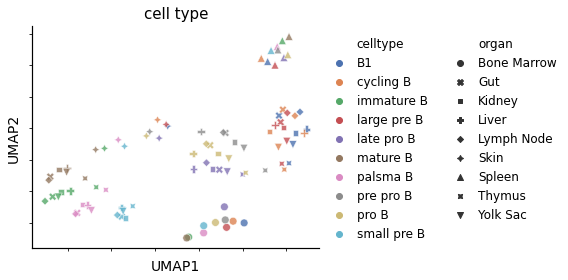

In [27]:

fig, axs = plt.subplots(1,1, figsize=(8,4))


sns.scatterplot(
    data=df, 
    x="umap1", 
    y="umap2", 
    hue="celltype",
    style="organ",
    ax=axs,  
    alpha=.8,
    s=60,
    palette="deep"
)



axs.set_title("cell type")
axs.set(xticklabels=[], yticklabels=[])
axs.set_xlabel("UMAP1")
axs.set_ylabel("UMAP2")
axs.grid(False)
axs.legend(loc="upper left", bbox_to_anchor=(1, 1), ncols=2)

plt.tight_layout()
plt.savefig(FIG_DIR + "cell_type.png", format="png", dpi=300)

plt.show()


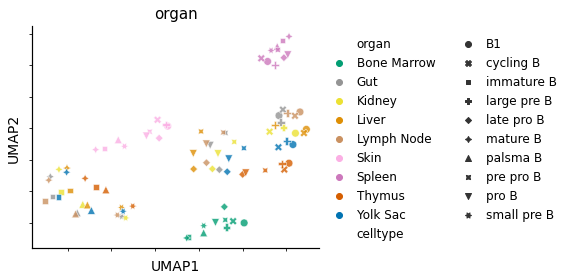

In [28]:
SAVEFIG = False
fig, axs = plt.subplots(1,1, figsize=(8,4))

sns.scatterplot(
    data=df, 
    x="umap1", 
    y="umap2", 
    hue="organ",
    style="celltype",
    ax=axs,  
    alpha=.8,
    s=60,
    palette=[
    "#029e73", 
    "#949494",
    "#ece133",
    "#de8f05",
    "#ca9161",
    "#fbafe4",
    "#cc78bc",
    "#d55e00",
    "#0173b2",
]
)


axs.set_title("organ")
axs.set(xticklabels=[], yticklabels=[])
axs.set_xlabel("UMAP1")
axs.set_ylabel("UMAP2")
axs.grid(False)
axs.legend(loc="upper left", bbox_to_anchor=(1, 1), ncols=2)

plt.tight_layout()
plt.savefig(FIG_DIR + "organ.png", format="png", dpi=300)

plt.show()


In [29]:
from cluster_analysis import rand_index
def cluster_evaluate(attribute_):
    ground_truth_labels = np.array(df[attribute_ + '_key'])
    print("Number of samples:", ground_truth_labels.size)
    print("ground truth labels:", ground_truth_labels, '\n')
    title = "Attribute: " + attribute_ 
    path = FIG_DIR + attribute_ + "_"
    scores = rand_index(transf_embeddings_attributes, ground_truth_labels, df, title, path)

Number of samples: 90
ground truth labels: [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4
 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 8 8
 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9] 



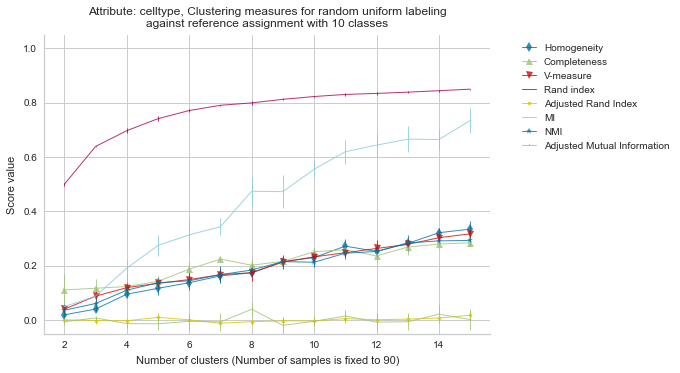

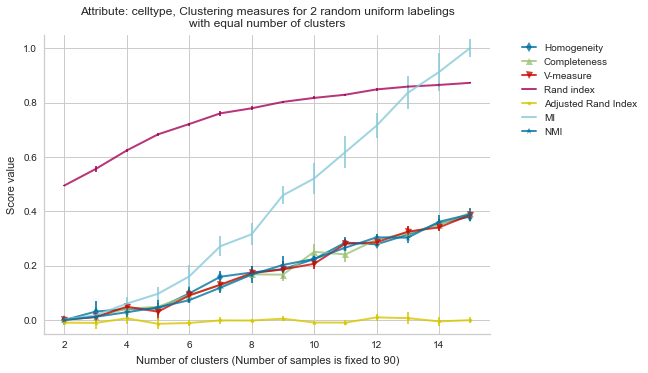

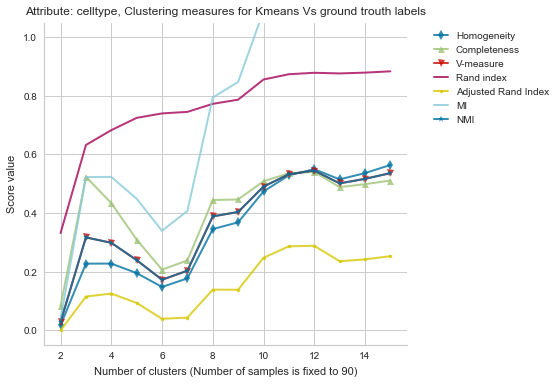

kmeans labels are: [ 7 10 10 10 10  8  4 10 10  7 10 10 10 10  8  4 10 10  7  5  5  5 11 11
  0  5  5  7  9  9  9  9  8  4  9  9  7  1  1  6  1  6  4  1  1  7 11 11
 11 11 11  0  5 11  7  3  3  3  3  8  0  5  3  7  1  1  1  1  8  4  1  1
  7  1  1  1  1  6  4  1  1  2  3  3  3  3  8  4  2  3]


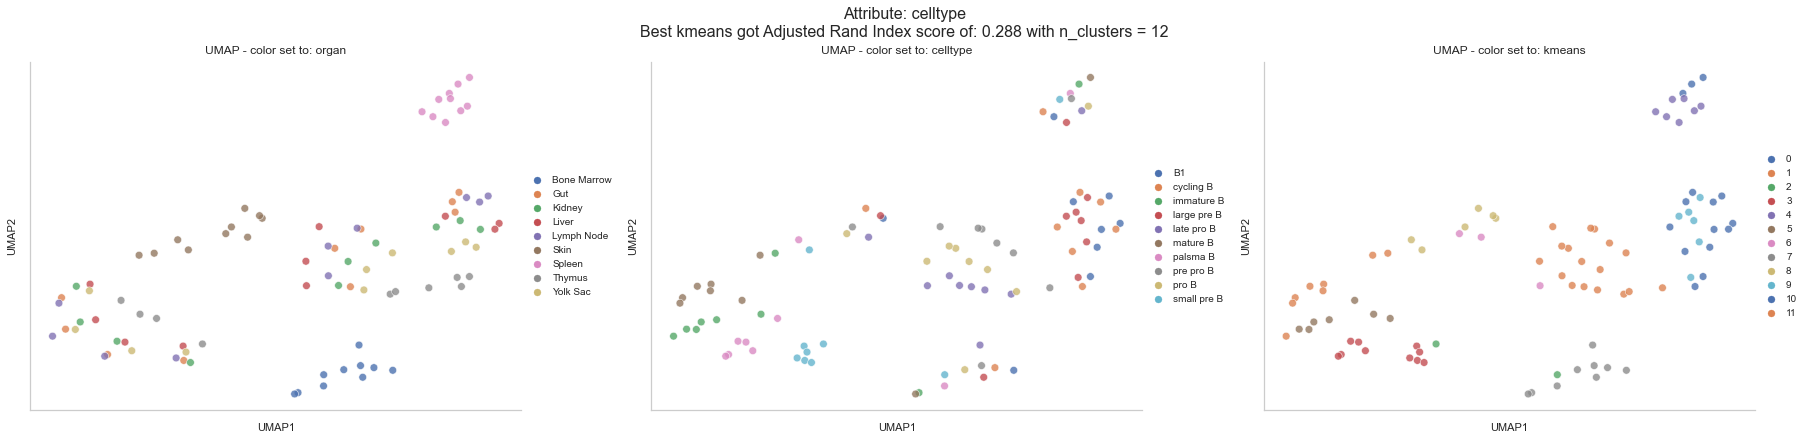

In [30]:
cluster_evaluate("celltype")

Number of samples: 90
ground truth labels: [0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0
 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1
 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8] 



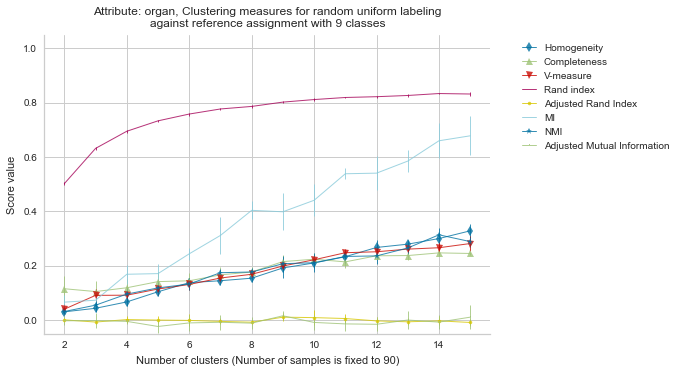

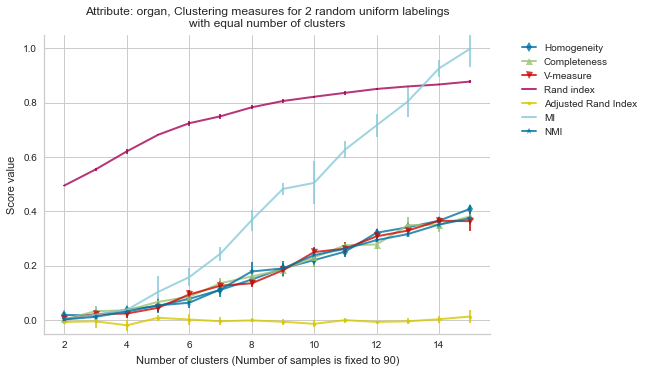

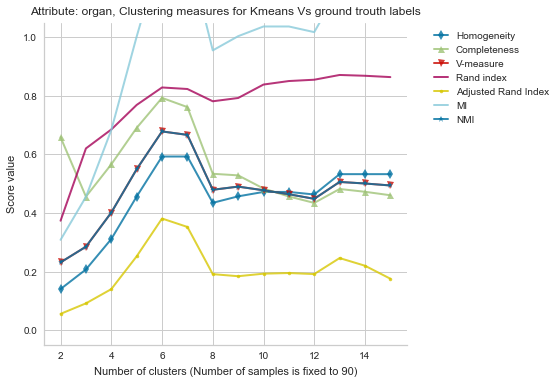

kmeans labels are: [2 1 1 1 1 4 0 3 1 2 1 1 1 1 4 0 3 1 2 5 5 5 5 4 0 3 5 2 1 1 1 1 4 0 3 1 2
 1 1 1 1 4 0 3 1 2 5 5 5 5 4 0 3 5 2 5 5 5 5 4 0 3 5 2 1 1 1 1 4 0 3 1 2 1
 1 1 1 4 0 3 1 2 1 1 1 1 4 0 3 1]


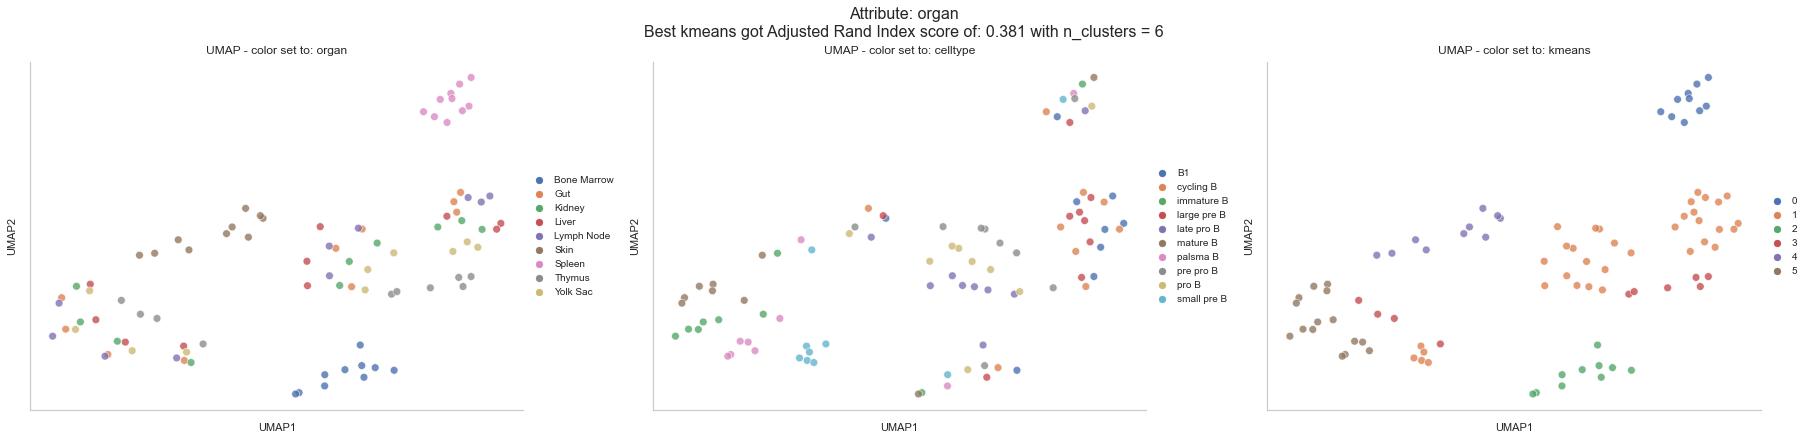

In [31]:
cluster_evaluate("organ")